### Run a PCA on games played by the player and see if there is any pattern

1. Import data and add interesting features
2. Run PCA and analyze results

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 250)

In [3]:
game_df = pd.read_pickle('./data/full_games_history.pkl')

In [108]:
# game_df.head()

In [4]:
print(game_df.columns)

# Keep only useful columns: Could be nice to add : 
#   - the time between player's moves
# features = ['url', 'pgn', 'time_control', 'Moves', 'PlayerElo',
#             'OpponentElo', 'EloDiff', 'PlayerSide', 'TerminationStatus', 'TerminationType',
#             'PlayerAccuracie', 'OpponentAccuracie', 'AccuracieDiff', 'Opening']

features = ['PlayerElo', 'OpponentElo', 'EloDiff', 'PlayerAccuracie', 'OpponentAccuracie', 'AccuracieDiff']

Index(['url', 'pgn', 'time_control', 'end_time', 'rated', 'tcn', 'uuid',
       'initial_setup', 'fen', 'time_class', 'rules', 'start_time',
       'player_profile', 'white_accuracie', 'black_accuracie', 'Event', 'Site',
       'Date', 'Round', 'White', 'Black', 'Result', 'CurrentPosition',
       'Timezone', 'ECO', 'ECOUrl', 'UTCDate', 'UTCTime', 'WhiteElo',
       'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate',
       'EndTime', 'Link', 'Moves', 'TerminationStatus', 'PlayerSide',
       'PlayerElo', 'OpponentElo', 'EloDiff', 'PlayerAccuracie',
       'OpponentAccuracie', 'AccuracieDiff', 'Duration', 'TerminationType',
       'Opening', 'AvgTimeWhite', 'AvgTimeBlack', 'StdTimeWhite',
       'StdTimeBlack', 'PlayerAvgTime', 'OpponentAvgTime', 'PlayerStdTime',
       'OpponentStdTime', 'AvgTimeDiff', 'StdTimeDiff'],
      dtype='object')


In [5]:
# Keep only game with an accuracie
df = game_df[features].loc[~game_df.AccuracieDiff.isna()].copy()
df.shape

(2387, 6)

In [154]:
# Scale data
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
# scaled_data

In [41]:
# Compute PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

Total of explained variance: 67.32%
Detail of PCA components: 


<AxesSubplot:title={'center':'Principale components decomposition'}>

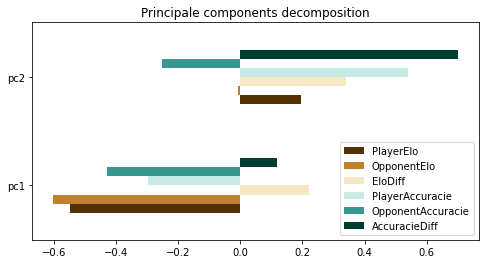

In [190]:
# Understand PCA results
print('Total of explained variance: {:.2f}%'.format(pca.explained_variance_ratio_.sum()*100))
print('Detail of PCA components: ')

comp_df = pd.DataFrame(pca.components_, columns=features)
comp_df.index = ['pc1', 'pc2']

comp_df.plot(kind='barh', colormap='BrBG', figsize=(8,4), title='Principale components decomposition')

(0.0, 1.0)

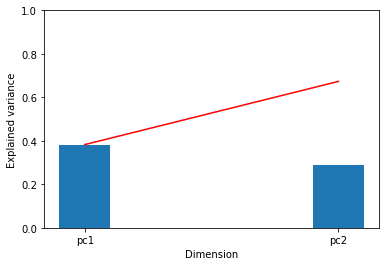

In [205]:
# Variance explained
plt.bar(['pc1','pc2'],pca.explained_variance_ratio_, width=0.2)
plt.plot(['pc1','pc2'], [pca.explained_variance_ratio_[0], pca.explained_variance_ratio_.sum()], color='red')
plt.xlabel('Dimension')
plt.ylabel('Explained variance')
plt.ylim(0,1)

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

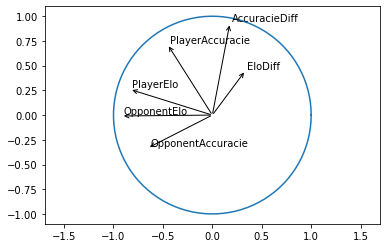

In [191]:
# Correlation circle of features and pca components
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
for i in range(scaled_data.shape[1]):
    x = np.corrcoef(x_pca[:,0], scaled_data[:,i])[0, 1]
    y = np.corrcoef(x_pca[:,1], scaled_data[:,i])[0, 1]
    plt.annotate('', xy = (x, y), xytext = (0,0), arrowprops = {'arrowstyle': '->'})
    plt.annotate(features[i], xy = (x + 0.02, y + 0.02))
plt.axis('equal')

In [54]:
target = game_df['TerminationStatus'].loc[~game_df.AccuracieDiff.isna()].reset_index(drop=True).copy()

def f(x):
    if x == 'Win':
        a = 1 
    elif x == 'Lose':
        a = -1 
    else: 
        a = 0
    return a

t = target.apply(f)

Text(0.5, 1.0, 'Projection of data points in new space defined by PC1 and PC2')

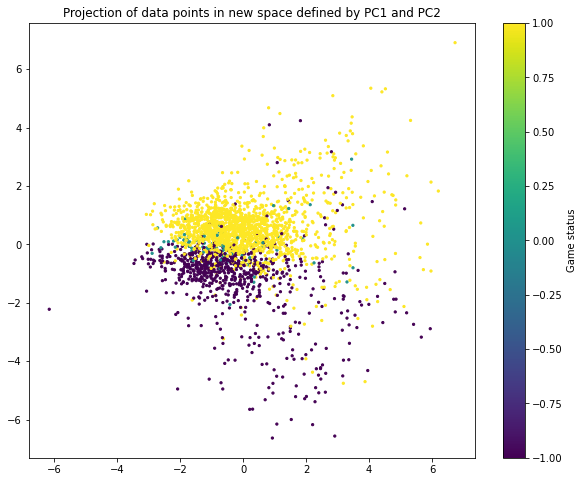

In [202]:
# Plot data points in the new space defined by PC1 and PC2
plt.figure(figsize=(10,8))
plt.scatter(x_pca[:,0], x_pca[:,1], c=t, s=5)
cbar = plt.colorbar()
cbar.set_label('Game status')
plt.title('Projection of data points in new space defined by PC1 and PC2')